In [1]:
import sys, os
sys.path.insert(1, '../python')
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/packages/vlasov_solver'))

In [2]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline


%matplotlib inline

In [3]:
def fast_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

def whistler_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return 1836 * kdi**2 / (1836 + kdi**2) * cos_theta   

def alfven_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    return kz / np.sqrt(betap)

def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

# single k

In [4]:
betap = .1
t_list=[1., 1., 1.]
a_list=[1., 2., 1.]
n_list=[1.,.5,.5] 
q_list=[1.,-1.,-1.]
m_list=[1., 1./1836.,1./1836.]
v_list=[0.,0.,0.]
n = 10
# theta = 20.
theta = 85.

kdi = .1
k = kdi_2_krhoi(kdi, betap)

kz, kp = kzkp(k, theta)
method = 'pade'
aol = 1e-3

print('kz = {0:.2g}'.format(kz))
param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

kz = 0.0028


In [5]:
fast = fast_freq(k, theta, betap)
alfven = alfven_freq(k, theta, betap)
print('alfven freq = {0:.2g}'.format(alfven))
print('fast freq = {0:.2g}'.format(fast))

# print('guess fast mode freq = {0:.2f}'.format(fast))

f = lambda wrel:\
    real_imag(oblique_wrapper(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = 'numpy', n = 10, \
                              aol=1e-4))
# guess = 1.55 - 0.01j
# guess = alfven
guess = fast
print('guess freq = {0:.2g}'.format(guess))
wr, wi = scipy.optimize.fsolve(f, real_imag(guess))

print(wr)
print(wi)

alfven freq = 0.0087
fast freq = 0.1
guess freq = 0.1
0.11208366055934997
-0.004397824351137686


In [6]:
# inp = input_gen(list_to_complex([wr, wi]), kp, kz, betap)

# tr = transport_ratios(inp, print_result = True)

In [7]:
# tr['eigen_e']

# Follow $k$

In [8]:
betap = 1.
t_list=[1.,1]
a_list=[1., 1.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1./1836.]
v_list=[0.,0.]
n = 6
aol = 1e-4
method = 'numpy'

theta = 30.

kdi = 1
k = kdi_2_krhoi(kdi, betap)
kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

In [9]:
target_kdi = 10
target_k = kdi_2_krhoi(target_kdi, betap)
print('target_k = {0:.2f}'.format(target_k))
print('target_kde = {0:.3g}'.format(target_kdi / np.sqrt(1836.)))

seed_freq = fast_freq(k, theta, betap)
f = lambda wrel:\
    real_imag(oblique_wrapper(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = method, n = n, \
                              aol=aol))
guess = seed_freq * (1-.6j)
print('seed_freq = {0:.3g}'.format(guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(guess))

print(r'found $\omega_r$ =', wr)
print(r'found $\omega_i$ =', wi)
print(wr/1836/np.cos(np.deg2rad(theta)))
freq = follow_k(seed_freq, target_k, param,
                log_incrmt = 0.1, incrmt_method = 'log')

target_k = 10.00
target_kde = 0.233
seed_freq = 1.32-0.794j
found $\omega_r$ = 1.2335483576517936
found $\omega_i$ = -0.5415359234864148
0.0007758055297915945


In [10]:
freq

((82.4008439385665-3.837001327330267j),
 (8.660254037844387,
  4.999999999999999,
  1.0,
  [1.0, 1],
  [1.0, 1.0],
  [1.0, 1.0],
  [1.0, -1.0],
  [1.0, 0.0005446623093681918],
  [0.0, 0.0],
  6,
  'numpy',
  0.0001),
 [(1.609602032557961-0.06590068974032744j),
  (1.8321339928466622-0.06572702365947736j),
  (2.0913955473985144-0.06458567874260428j),
  (2.3946708441698488-0.06252330683961636j),
  (2.7509858022503755-0.05978205843806643j),
  (3.171535967393409-0.05687356453079808j),
  (3.670206644662738-0.05464323263623219j),
  (4.264199241096688-0.0542929543913718j),
  (4.974753583075996-0.05732996748838916j),
  (5.827929230358926-0.06543470640966888j),
  (6.855397964566456-0.08029545677801032j),
  (8.095240905030527-0.10352871446619293j),
  (9.592857611584595-0.13682359455700727j),
  (11.402197365240621-0.1823327715441373j),
  (13.587452890314312-0.24315472680932268j),
  (16.22515566291738-0.3237367116232238j),
  (19.406523091178638-0.4301771955125966j),
  (23.23997987761521-0.570530380

# Parameter conversion

$$\frac{c}{v_A} = \sqrt{\frac{m_p}{m_e}} \frac{\omega_{pe}}{\omega_{ce}}$$
$$\beta_p = \frac{v_{Tp}^2}{v_A^2} = \frac{m_e}{m_p} \frac{T_p}{T_e} \frac{v_{Te, h}^2}{v_A^2}$$

Given that $$v_{Te, h} = 0.6 c \omega_{ce} \cos\theta / \omega_{pe}$$

$$\beta_p = \frac{T_p}{T_e} 0.72 \cos{\theta}^2$$

In [11]:
theta = 30.
wpe_wce = 4
the_tp = 60
# the_tp = 1
fac = 0.6
# fac = 1e-2
# ===============

aol = 1/np.sqrt(1836)/wpe_wce
betap = 1/the_tp * np.cos(np.deg2rad(theta))**2 * 2* 2*fac**2

print('aol = {0:.4g}'.format(aol))
print('beta_p = {0:.4g}'.format(betap))

aol = 0.005835
beta_p = 0.018


In [12]:
#=============
theta = 0.1
betap = 1.
aol = 1e-4
the_tp = 1
#=============
tc_th = 5
# tc_th = 0.5

t_list=[1., the_tp, the_tp * tc_th]
a_list=[1., 1., 1.]
n_list=[1.,.95,.05] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0., -2, 38]
n = 10
method = 'pade'

kdi = 1

target_kde = 3
target_kdi = target_kde * np.sqrt(1836)

k = kdi_2_krhoi(kdi, betap)
kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

In [13]:
target_k = kdi_2_krhoi(target_kdi, betap)
print('target_k = {0:.2f}'.format(target_k))
print('target_kde = {0:.3g}'.format(target_kdi / np.sqrt(1836.)))

seed_freq = fast_freq(k, theta, betap)
print('seed_freq = {0:.3g}'.format(seed_freq))
freq = follow_k(seed_freq, target_k, param,
                log_incrmt = 0.01, incrmt_method = 'log')

target_k = 128.55
target_kde = 3
seed_freq = 1.41


In [14]:
freq_arr = np.array(freq[-1])
# print(freq_arr[::5])

In [15]:
kde_start = kdi / np.sqrt(1836)
kde_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2) /np.sqrt(1836) / np.sqrt(betap)

In [16]:
kdi_2_krhoi(kde_end * np.sqrt(1836), betap)

128.54571171377134

In [17]:
kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(freq_arr))

In [18]:
krhoi_list = np.logspace(np.log10(k), np.log10(target_k), len(freq_arr))

In [19]:
fast_list = np.array([fast_freq(k, theta, betap) for k in krhoi_list])
whistler_list = np.array([whistler_freq(k, theta, betap) for k in krhoi_list])

In [20]:
nc_nh = n_list[2] / n_list[1]
ea_list = krhoi_list * np.cos(np.deg2rad(theta)) * np.sqrt(0.5 * 1836 * the_tp * (nc_nh/(1+nc_nh)))

ea_list_2 = kde_list * fac * np.sqrt(nc_nh / (1+nc_nh))



In [21]:
# ea_list/1836/np.cos(np.deg2rad(theta))/ea_list_2

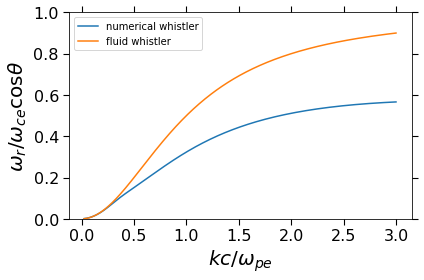

In [23]:
plt.plot(kde_list, freq_arr.real/1836/np.cos(np.deg2rad(theta)), '-', label = 'numerical whistler')
# plt.plot(kde_list, fast_list/1836/np.cos(np.deg2rad(theta)), label = 'fluid fast')
plt.plot(kde_list, whistler_list/1836/np.cos(np.deg2rad(theta)), label = 'fluid whistler')
# plt.plot(kde_list, ea_list/1836/np.cos(np.deg2rad(theta)), label = 'fluid EA')
# plt.plot(kde_list, ea_list_2/np.cos(np.deg2rad(theta)), label = 'fluid EA 2')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()
# plt.savefig('whistler_dispersion_real_1.png')

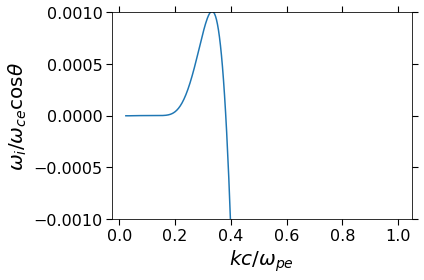

In [155]:
plt.plot(kde_list, freq_arr.imag/1836/np.cos(np.deg2rad(theta)))
# plt.plot(kde_list, freq_arr.imag/freq_arr.real)
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylim([-1e-3, 1e-3])
plt.tight_layout()
# plt.savefig('whistler_dispersion_imag_1.png')

# Transport ratios

In [157]:
k_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2)
k_start = kdi_2_krhoi(kdi, betap)
k_list = np.logspace(np.log10(k_start), np.log10(k_end), len(freq_arr))

ex_ez_list = []
ey_ez_list = []
by_bx_list = []
by_bx_imag_list = []

eigen_e_list = []
eigen_b_list = []

for i in range(len(k_list)):
    freq_i = freq_arr[i]
    kz, kp = kzkp(k_list[i], theta)
#     inp = input_gen(freq_i, kp, kz, betap)
    inp = input_gen(freq_i, kz, kp, betap, t_list, \
              a_list, n_list, q_list, m_list, v_list, \
              n, method = method, aol=aol)
    tr = transport_ratios(inp, print_result = False)
    eigen_e = tr['eigen_e']
    kvec = np.array([kp, 0, kz])
    khat = kvec/np.linalg.norm(kvec)
    ez_prime = np.dot(eigen_e, khat) * khat
    ey_prime = np.array([0, eigen_e[1], 0])
    ex_prime = eigen_e - ez_prime - ey_prime
    ex_ez = np.linalg.norm(ex_prime) / np.linalg.norm(ez_prime)
    ey_ez = np.linalg.norm(ey_prime) / np.linalg.norm(ez_prime)
    ex_ez_list.append(ex_ez)
    ey_ez_list.append(ey_ez)
    
    eigen_e_list.append(eigen_e)
    
    eigen_b = np.cross(kvec, eigen_e)
    bz_prime = np.dot(eigen_b, khat) * khat
    by_prime = np.array([0, eigen_b[1], 0])
    bx_prime = eigen_b - bz_prime - by_prime
    by_bx = np.linalg.norm(bx_prime) / np.linalg.norm(by_prime)
#     by_bx_imag = (bx_prime / by_prime).imag
#     by_bx_imag_list.append(by_bx_imag)
    by_bx_list.append(by_bx)
        
    eigen_b_list.append(eigen_b)

In [158]:
np.linalg.norm(bx_prime)

42.84857057125709

In [159]:
np.linalg.norm(by_prime)

42.84858961637334

In [160]:
eigen_b

array([  0.        +4.28485053e+01j, -42.84858962+3.65886590e-05j,
         0.        -7.47848257e-02j])

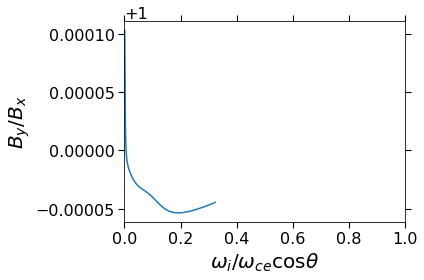

In [104]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), by_bx_list, '-', markersize=1)
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$B_y/B_x$')
# plt.axhline(1, linestyle='dashed', color='k')
# plt.ylim([0.8, 2.6])
plt.xlim([0, 1.])
plt.tight_layout()
# plt.savefig('whistler_byex_1.png')

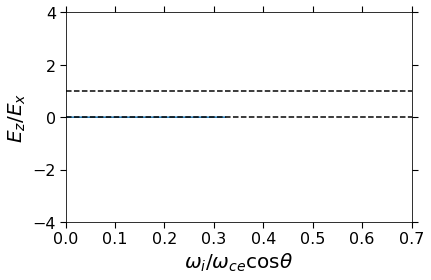

In [161]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), [np.abs(np.linalg.norm(e[2]/e[0])) for e in eigen_e_list], '-')
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$E_z/E_x$')
plt.axhline(1, linestyle='dashed', color='k')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([-4, 4])
plt.xlim([0, 0.7])
plt.tight_layout()
# plt.savefig('whistler_eyez_1.png')

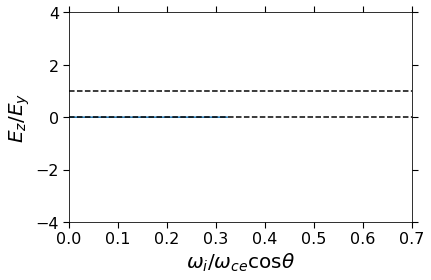

In [162]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), [np.abs(np.linalg.norm(e[2]/e[1])) for e in eigen_e_list], '-')
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$E_z/E_y$')
plt.axhline(1, linestyle='dashed', color='k')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([-4, 4])
plt.xlim([0, 0.7])
plt.tight_layout()
# plt.savefig('whistler_eyez_1.png')

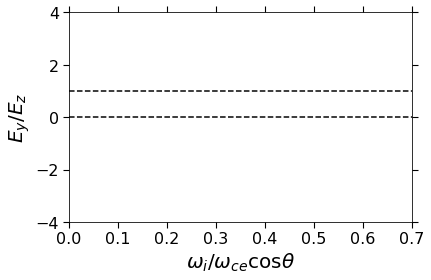

In [163]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), ex_ez_list, '-')
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$E_y/E_z$')
plt.axhline(1, linestyle='dashed', color='k')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([-4, 4])
plt.xlim([0, 0.7])
plt.tight_layout()
# plt.savefig('whistler_eyez_1.png')

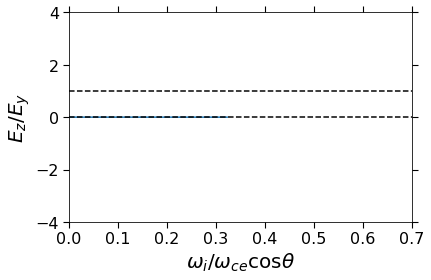

In [164]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), 1/np.array(ex_ez_list), '-')
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$E_z/E_y$')
plt.axhline(1, linestyle='dashed', color='k')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([-4, 4])
plt.xlim([0, 0.7])
plt.tight_layout()
# plt.savefig('whistler_eyez_1.png')

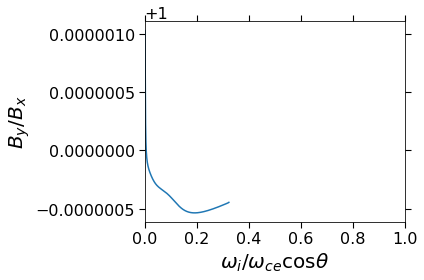

In [165]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), by_bx_list, '-', markersize=1)
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$B_y/B_x$')
# plt.axhline(1, linestyle='dashed', color='k')
# plt.ylim([0.8, 2.6])
plt.xlim([0, 1.])
plt.tight_layout()
# plt.savefig('whistler_byex_1.png')

In [84]:
# np.save('data/whistler_freq_nh_02', freq_arr/1836/np.cos(np.deg2rad(theta)))
# np.save('data/whistler_eyez_nh_02', ey_ez_list)
# np.save('data/whistler_bybx_nh_02', by_bx_list)

In [86]:
# np.save('data/whistler_kde', kde_list)

# Dependence on fraction of hot components

In [87]:
kde = np.load('data/whistler_kde.npy')

freq_01 = np.load('data/whistler_freq_nh_01.npy')
freq_02 = np.load('data/whistler_freq_nh_02.npy')
freq_04 = np.load('data/whistler_freq_nh_04.npy')

eyez_01 = np.load('data/whistler_eyez_nh_01.npy')
eyez_02 = np.load('data/whistler_eyez_nh_02.npy')
eyez_04 = np.load('data/whistler_eyez_nh_04.npy')

bybx_01 = np.load('data/whistler_bybx_nh_01.npy')
bybx_02 = np.load('data/whistler_bybx_nh_02.npy')
bybx_04 = np.load('data/whistler_bybx_nh_04.npy')

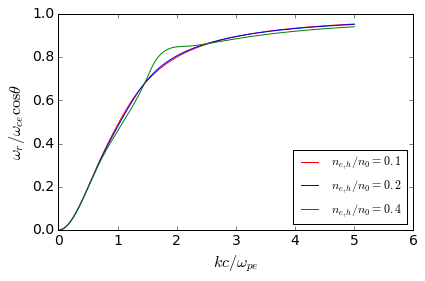

In [109]:
plt.plot(kde, freq_01.real, 'r', label=r'$n_{e,h}/n_0 = 0.1$')
plt.plot(kde, freq_02.real, 'b', label=r'$n_{e,h}/n_0 = 0.2$')
plt.plot(kde, freq_04.real, 'g', label=r'$n_{e,h}/n_0 = 0.4$')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylim([0, 1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('whistler_dispersion_real_comparison.png')

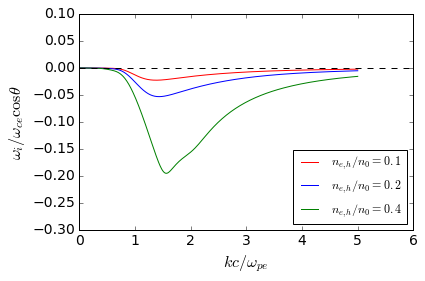

In [110]:
plt.plot(kde, freq_01.imag, 'r', label=r'$n_{e,h}/n_0 = 0.1$')
plt.plot(kde, freq_02.imag, 'b', label=r'$n_{e,h}/n_0 = 0.2$')
plt.plot(kde, freq_04.imag, 'g', label=r'$n_{e,h}/n_0 = 0.4$')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylim([-.3, 0.1])
plt.axhline(0, linestyle='dashed', color = 'k')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('whistler_dispersion_imag_comparison.png')

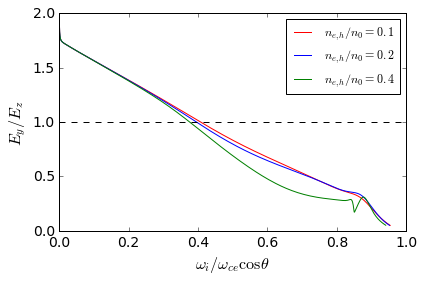

In [117]:
plt.plot(freq_01.real, eyez_01, 'r', label=r'$n_{e,h}/n_0 = 0.1$')
plt.plot(freq_02.real, eyez_02, 'b', label=r'$n_{e,h}/n_0 = 0.2$')
plt.plot(freq_04.real, eyez_04, 'g', label=r'$n_{e,h}/n_0 = 0.4$')
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$E_y/E_z$')
plt.axhline(1, linestyle='dashed', color='k')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([0, 2])
# plt.xlim([0, 0.7])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('whistler_eyez_comparision.png')

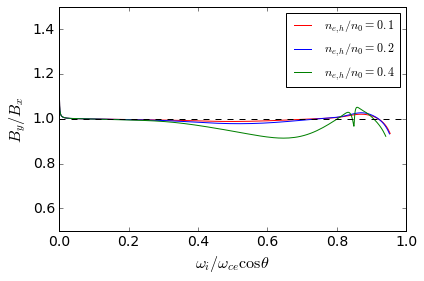

In [118]:
plt.plot(freq_01.real, bybx_01, 'r', label=r'$n_{e,h}/n_0 = 0.1$')
plt.plot(freq_02.real, bybx_02, 'b', label=r'$n_{e,h}/n_0 = 0.2$')
plt.plot(freq_04.real, bybx_04, 'g', label=r'$n_{e,h}/n_0 = 0.4$')
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$B_y/B_x$')
plt.axhline(1, linestyle='dashed', color='k')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([0.5, 1.5])
# plt.xlim([0, 0.7])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('whistler_bybx_comparision.png')

In [121]:
!ls figure/

whistler_bybx_comparision.png           whistler_dispersion_real_1.png
whistler_byex_1.png                     whistler_dispersion_real_comparison.png
whistler_dispersion_imag_1.png          whistler_eyez_1.png
whistler_dispersion_imag_comparison.png whistler_eyez_comparision.png
